In [ ]:
!pip install watermark

In [3]:
%load_ext watermark
%watermark -p torch,pytorch_lightning,torchmetrics,matplotlib

torch            : 1.10.0+cu111
pytorch_lightning: not installed
torchmetrics     : not installed
matplotlib       : 3.2.2



In [ ]:
!pip install pycodestyle_magic

In [ ]:
!pip install pytorch_lightning

In [16]:
BATCH_SIZE = 256
NUM_EPOCHS = 40
LEARNING_RATE = 0.001
NUM_WORKERS = 4

In [18]:
import torch 
import torch.nn as nn
import torch.nn.functional as F


# Regular PyTorch Module
class PyTorchAlexNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        logits = self.classifier(x)
        return logits

In [19]:
import pytorch_lightning as pl
import torchmetrics


# LightningModule that receives a PyTorch model as input
class LightningModel(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate
        # The inherited PyTorch module
        self.model = model

        # Save settings and hyperparameters to the log directory
        # but skip the model parameters
        self.save_hyperparameters(ignore=['model'])

        # Set up attributes for computing the accuracy
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()
        self.test_acc = torchmetrics.Accuracy()
        
    # Defining the forward method is only necessary 
    # if you want to use a Trainer's .predict() method (optional)
    def forward(self, x):
        return self.model(x)
        
    # A common forward step to compute the loss and labels
    # this is used for training, validation, and testing below
    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)
        loss = torch.nn.functional.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)

        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("train_loss", loss)
        
        # To account for Dropout behavior during evaluation
        self.model.eval()
        with torch.no_grad():
            _, true_labels, predicted_labels = self._shared_step(batch)
        self.train_acc.update(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, on_epoch=True, on_step=False)
        self.model.train()
        return loss  # this is passed to the optimzer for training

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("valid_loss", loss)
        self.valid_acc(predicted_labels, true_labels)
        self.log("valid_acc", self.valid_acc,
                 on_epoch=True, on_step=False, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc, on_epoch=True, on_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [20]:
import torch

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader


train_dataset = datasets.CIFAR10(root='./data', 
                                 train=True, 
                                 transform=transforms.ToTensor(),
                                 download=True)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          num_workers=NUM_WORKERS,
                          drop_last=True,
                          shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', 
                                train=False,
                                transform=transforms.ToTensor())

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=NUM_WORKERS,
                         drop_last=False,
                         shuffle=False)

# Checking the dataset
all_train_labels = []
all_test_labels = []

for images, labels in train_loader:  
    all_train_labels.append(labels)
all_train_labels = torch.cat(all_train_labels)
    
for images, labels in test_loader:  
    all_test_labels.append(labels)
all_test_labels = torch.cat(all_test_labels)

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [21]:
print('Training labels:', torch.unique(all_train_labels))
print('Training label distribution:', torch.bincount(all_train_labels))

print('\nTest labels:', torch.unique(all_test_labels))
print('Test label distribution:', torch.bincount(all_test_labels))

Training labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Training label distribution: tensor([4989, 4990, 4993, 4989, 4993, 4996, 4991, 4991, 4994, 4994])

Test labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Test label distribution: tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])


In [22]:
majority_prediction = torch.argmax(torch.bincount(all_test_labels))
baseline_acc = torch.mean((all_test_labels == majority_prediction).float())
print(f'Baseline ACC: {baseline_acc*100:.2f}%')

Baseline ACC: 10.00%


In [23]:
import os

from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torchvision import transforms


class DataModule(pl.LightningDataModule):
    def __init__(self, data_path='./'):
        super().__init__()
        self.data_path = data_path
        
    def prepare_data(self):
        datasets.CIFAR10(root=self.data_path,
                         download=True)
        
        self.train_transform = transforms.Compose(
            [transforms.Resize((70, 70)),
             transforms.RandomCrop((64, 64)),
             transforms.ToTensor()])

        self.test_transform = transforms.Compose(
            [transforms.Resize((70, 70)),
             transforms.CenterCrop((64, 64)),
             transforms.ToTensor()])
        return

    def setup(self, stage=None):
        train = datasets.CIFAR10(root=self.data_path, 
                                 train=True, 
                                 transform=self.train_transform,
                                 download=False)

        self.test = datasets.CIFAR10(root=self.data_path, 
                                     train=False, 
                                     transform=self.test_transform,
                                     download=False)

        self.train, self.valid = random_split(train, lengths=[45000, 5000])

    def train_dataloader(self):
        train_loader = DataLoader(dataset=self.train, 
                                  batch_size=BATCH_SIZE, 
                                  drop_last=True,
                                  shuffle=True,
                                  num_workers=NUM_WORKERS)
        return train_loader

    def val_dataloader(self):
        valid_loader = DataLoader(dataset=self.valid, 
                                  batch_size=BATCH_SIZE, 
                                  drop_last=False,
                                  shuffle=False,
                                  num_workers=NUM_WORKERS)
        return valid_loader

    def test_dataloader(self):
        test_loader = DataLoader(dataset=self.test, 
                                 batch_size=BATCH_SIZE, 
                                 drop_last=False,
                                 shuffle=False,
                                 num_workers=NUM_WORKERS)
        return test_loader

In [24]:
torch.manual_seed(1) 
data_module = DataModule(data_path='./data')

In [25]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger


pytorch_model = PyTorchAlexNet(num_classes=10)

lightning_model = LightningModel(
    pytorch_model, learning_rate=LEARNING_RATE)

callbacks = [ModelCheckpoint(
    save_top_k=1, mode='max', monitor="valid_acc")]  # save top 1 model 
logger = CSVLogger(save_dir="logs/", name="my-model")

In [26]:
import time


trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    callbacks=callbacks,
    progress_bar_refresh_rate=50,  # recommended for notebooks
    accelerator="auto",  # Uses GPUs or TPUs if available
    devices="auto",  # Uses all available GPUs/TPUs if applicable
    logger=logger,
    log_every_n_steps=100)

start_time = time.time()
trainer.fit(model=lightning_model, datamodule=data_module)

runtime = (time.time() - start_time)/60
print(f"Training took {runtime:.2f} min in total.")

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=50)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | model     | PyTorchAlexNet | 57.0 M
1 | train_acc | Accuracy       | 0     
2 | valid_acc | Accuracy       | 0     
3 | test_acc  | Accuracy       | 0     
---------------------------------------------
57.0 M    Trainable params
0         Non-trainable params
57.0 M    Total params
228.179   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training took 14.25 min in total.


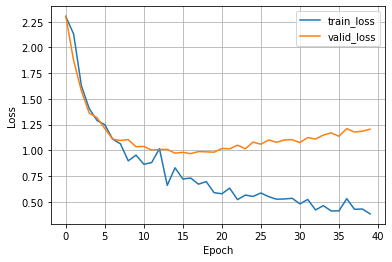

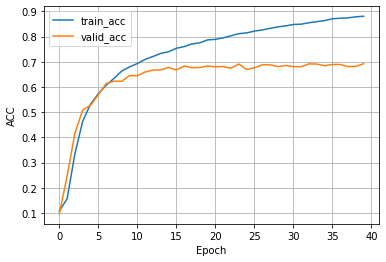

In [27]:
import pandas as pd


metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "valid_loss"]].plot(
    grid=True, legend=True, xlabel='Epoch', ylabel='Loss')
df_metrics[["train_acc", "valid_acc"]].plot(
    grid=True, legend=True, xlabel='Epoch', ylabel='ACC')

In [28]:
trainer.test(model=lightning_model, datamodule=data_module, ckpt_path='best')

Restoring states from the checkpoint path at logs/my-model/version_0/checkpoints/epoch=39-step=6999.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/my-model/version_0/checkpoints/epoch=39-step=6999.ckpt
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.6934000253677368}
--------------------------------------------------------------------------------


[{'test_acc': 0.6934000253677368}]

In [29]:
path = trainer.checkpoint_callback.best_model_path
print(path)

logs/my-model/version_0/checkpoints/epoch=39-step=6999.ckpt


In [30]:
lightning_model = LightningModel.load_from_checkpoint(
    path, model=pytorch_model)
lightning_model.eval();

In [31]:
test_dataloader = data_module.test_dataloader()

all_true_labels = []
all_predicted_labels = []
for batch in test_dataloader:
    features, labels = batch
    
    with torch.no_grad():  # since we don't need to backprop
        logits = lightning_model(features)

    predicted_labels = torch.argmax(logits, dim=1)
    all_predicted_labels.append(predicted_labels)
    all_true_labels.append(labels)
    
all_predicted_labels = torch.cat(all_predicted_labels)
all_true_labels = torch.cat(all_true_labels)
all_predicted_labels[:5]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([3, 1, 1, 0, 4])

In [32]:
test_acc = torch.mean((all_predicted_labels == all_true_labels).float())
print(f'Test accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)')

Test accuracy: 0.6935 (69.35%)
